In [1]:
import json
import transformers
import pandas as pd
from transformers import (DataCollatorForSeq2Seq, 
                          AutoTokenizer, 
                          AutoModelForCausalLM, 
                          BloomForCausalLM,
                          Seq2SeqTrainingArguments, 
                          Seq2SeqTrainer,
                          Trainer,
                          TrainerCallback,
                          )

from wordcloud import WordCloud
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

import nltk 
import string
from collections import Counter
import beeprint
from nltk.corpus import stopwords


/hhome/nlp2_g05/anaconda3/envs/asho_nlp/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


# Clean sythetic data

## CASTELLA LLAMA 70B

In [2]:
# Load the summaries generated by LLAMA3-70B
with open('/hhome/nlp2_g05/Asho_NLP/src/final_summaries_llama3_70B.json', 'r') as f:
    summaries = json.load(f)

In [3]:
# Clean the summaries, removing the prefixes that are not part of the summary itself
# As some summaries have the prefix "Summary:", "Here is the summary:", etc.
_values = list(summaries.values())
summaries_ = [value['summary'] for value in _values]
cleaned_summaries = [" ".join(resumen.split(":")[1:]) if resumen.find(':') != -1 else resumen for resumen in summaries_]

In [4]:
# Modify the summaries with the cleaned ones
for key, new_summari in zip(summaries, cleaned_summaries):
    summaries[key]['summary'] = new_summari

In [5]:
# Save the cleaned summaries
with open('/hhome/nlp2_g05/Asho_NLP/src/CLEANED_final_summaries_llama3_70B.json', 'w') as f:
    json.dump(summaries, f, indent=4)

## CATALA LLAMA 70 B

In [6]:
# Load the summaries generated by LLAMA3-70B in catalan
with open('/hhome/nlp2_g05/Asho_NLP/src/CAT_final_summaries_llama3_70B.json', 'r') as f:
    summaries = json.load(f)

In [7]:
# Clean the summaries, removing the prefixes that are not part of the summary itself
# As some summaries have the prefix "Summary:", "Here is the summary:", etc.
_values = list(summaries.values())
summaries_ = [value['summary'] for value in _values]
cleaned_summaries = [" ".join(resumen.split(":")[1:]) if resumen.find(':') != -1 else resumen for resumen in summaries_]

In [8]:
# Modify the summaries with the cleaned ones
for key, new_summari in zip(summaries, cleaned_summaries):
    summaries[key]['summary'] = new_summari

In [9]:
# Save the cleaned summaries
with open('/hhome/nlp2_g05/Asho_NLP/src/CLEANED_CAT_final_summaries_llama3_70B.json', 'w') as f:
    json.dump(summaries, f, indent=4)

# Medical Reports

In [10]:
# Load the summaries generated by LLAMA3-70B in catalan and spanish
with open("/hhome/nlp2_g05/Asho_NLP/src/CLEANED_CAT_final_summaries_llama3_70B.json", "r") as f:
    cat_data = json.load(f)
with open("/hhome/nlp2_g05/Asho_NLP/src/CLEANED_final_summaries_llama3_70B.json", "r") as f:
    cast_data = json.load(f)
    
# Original dataset with ground truth summaries
original_ = pd.read_json('/hhome/nlp2_g05/Asho_NLP/src/Datasets/Asho_Dataset/train_cleaned.json')


# Loading the model (FLOR-760M) tokenizer
model_name_pretrain = 'Pretrain_FLOR_Articles_summarization_v2'
checkpoint = f"/hhome/nlp2_g05/Asho_NLP/src/Trained_models/last_model_{model_name_pretrain}"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [11]:
# Load the different medical reports and the corresponding synthetic summaries 
text_= []
summaries_ = []

for value_cat, value_cast in zip(cat_data.values(), cast_data.values()):
    text_.append(value_cast["Text"])
    text_.append(value_cat["Text"])
    summaries_.append(value_cast["summary"])
    summaries_.append(value_cat["summary"])

In [12]:
# Tokenize the medical reports and the summaries
tokens_text = tokenizer(text_)
tokens_summaries = tokenizer(summaries_)

In [13]:
# Computing basic statistics
total_len_tokens_text = 0
total_len_summaries = 0

numb_documents = 814
tokens_texts = [len(tokens_text[i]) for i in range(numb_documents)]
tokens_summaries = [len(tokens_summaries[i]) for i in range(numb_documents)]

total_len_tokens_text = sum(tokens_texts)
total_len_summaries = sum(tokens_summaries)

mean_tokens_text = total_len_tokens_text/numb_documents
mean_tokens_summaries = total_len_summaries/numb_documents

print("Mean tokens medical reports: ", mean_tokens_text)
print("Median tokens medical reports: ", pd.Series(tokens_texts).median())

print("Mean tokens summaries: ", mean_tokens_summaries)
print("Median tokens summaries: ", pd.Series(tokens_summaries).median())

print("Total tokens text: ", total_len_tokens_text)
print("Total tokens summaries: ", total_len_summaries)

Mean tokens medical reports:  1490.8083538083538
Median tokens medical reports:  1222.0
Mean tokens summaries:  120.10933660933661
Median tokens summaries:  119.0
Total tokens text:  1213518
Total tokens summaries:  97769


#### Lenght distribution of the ground truth examples

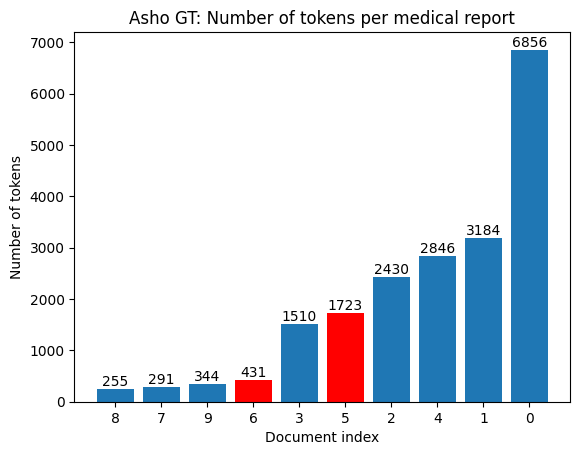

In [18]:
# Load the ground truth summariesv and the medical reports
asho_train_gt = pd.read_json('/hhome/nlp2_g05/Asho_NLP/src/Datasets/Asho_Dataset/train_cleaned.json')

# Computing the number of tokens for the ground truth summaries
tokenized_original = tokenizer(asho_train_gt['Text'].values.tolist())
tokens_texts_org = [len(tokenized_original[i]) for i in range(10)]

# Bar plot with the number of tokens per medical report
y, indixes = list(zip(*sorted(zip(tokens_texts_org, range(10)), key=lambda x: x[0], reverse=False)))
plt.bar(range(10), sorted(tokens_texts_org))
for i in range(10):
    plt.text(i, sorted(tokens_texts_org)[i], str(sorted(tokens_texts_org)[i]), ha='center', va='bottom')
# Put in the x axis the labels from indixes
l = plt.xticks(range(10), indixes)
# Put a title on the xaxis
plt.xlabel('Document index')
plt.ylabel('Number of tokens')
# Mark the columns in red of indices 5 and 6
plt.bar(5, tokens_texts_org[5], color='red')
plt.bar(3, tokens_texts_org[6], color='red')
plt.title('Asho GT: Number of tokens per medical report')
plt.show()

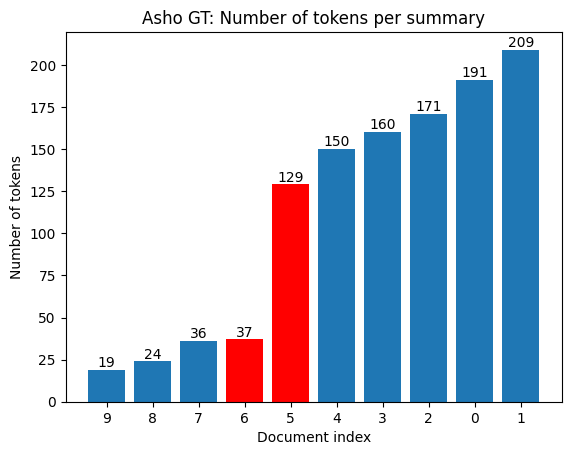

In [16]:
# Tokenize the ground truth summaries
tokenized_original = tokenizer(asho_train_gt['Summary'].values.tolist())
tokens_texts_org = [len(tokenized_original[i]) for i in range(10)]

# Bar plot with the number of tokens per summary
y, indixes = list(zip(*sorted(zip(tokens_texts_org, range(10)), key=lambda x: x[0], reverse=False)))
plt.bar(range(10), sorted(tokens_texts_org))
for i in range(10):
    plt.text(i, sorted(tokens_texts_org)[i], str(sorted(tokens_texts_org)[i]), ha='center', va='bottom')
# Put in the x axis the labels from indixes
l = plt.xticks(range(10), indixes)
# Put a title on the xaxis
plt.xlabel('Document index')
plt.ylabel('Number of tokens')
# Mark the columns in red of indices 5 and 6
plt.bar(4, tokens_texts_org[5], color='red')
plt.bar(3, tokens_texts_org[6], color='red')
plt.title('Asho GT: Number of tokens per summary')
plt.show()

#### Lenght distribution training dataset 

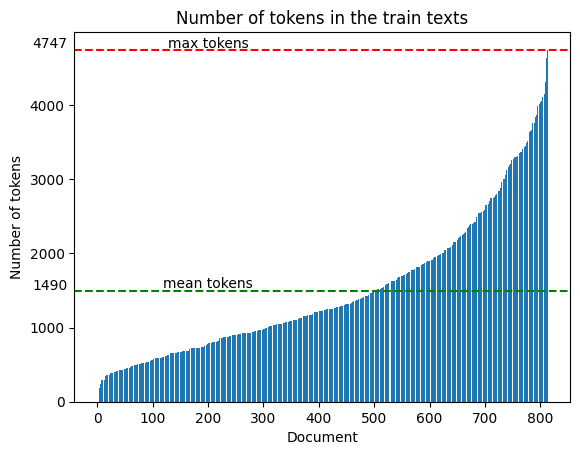

In [129]:
# Distribution of the number of tokens in the medical reports
plt.bar(range(numb_documents), sorted(tokens_texts))
plt.xlabel('Document')
plt.ylabel('Number of tokens')
plt.axhline(y=sorted(tokens_texts)[-1], color='r', linestyle='--')
plt.axhline(y=mean_tokens_text, color='g', linestyle='--')
plt.text(-85, sorted(tokens_texts)[-1] + 20, sorted(tokens_texts)[-1], ha = 'center')
plt.text(-85, mean_tokens_text + 20, int(mean_tokens_text), ha = 'center')
plt.text(200, sorted(tokens_texts)[-1] + 30, "max tokens", ha = 'center')
plt.text(200,  mean_tokens_text + 40, "mean tokens", ha = 'center')
plt.title('Number of tokens in the train medical reports')
plt.show()

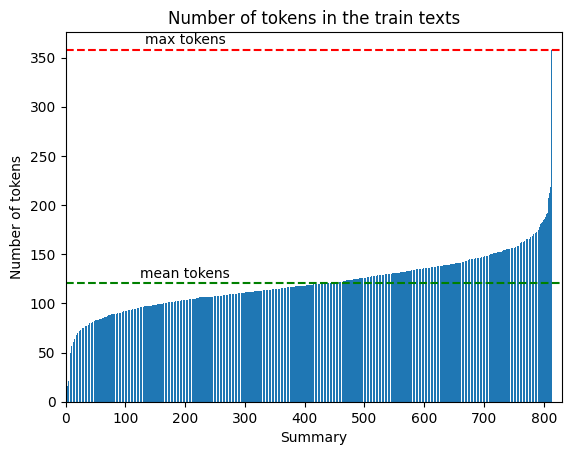

In [132]:
# Distribution of the number of tokens in the synthetic summaries
plt.bar(range(numb_documents), sorted(tokens_summaries))
plt.xlabel('Summary')
plt.ylabel('Number of tokens')

# Put a horizontal line on the top value indicate and add the value in the y-axis
plt.axhline(y=sorted(tokens_summaries)[-1], color='r', linestyle='--')
plt.axhline(y=mean_tokens_summaries, color='g', linestyle='--')
# plt.text(-85, sorted(tokens_summaries)[-1] + 20, sorted(tokens_summaries)[-1], ha = 'center')
# plt.text(-85, mean_tokens_summaries + 20, int(mean_tokens_summaries), ha = 'center')
plt.text(200, sorted(tokens_summaries)[-1] + 6, "max tokens", ha = 'center')
plt.text(200,  mean_tokens_summaries + 6, "mean tokens", ha = 'center')
plt.title('Number of tokens in the train texts')
plt.xlim(0, 830)
plt.show()

#### Wordclouds analysis

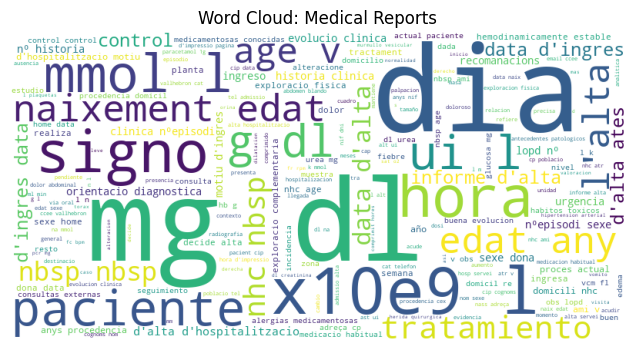

In [10]:
# Word cloud of the medical reports
text = ' '.join(text_)
stop_words = stopwords.words('spanish') + stopwords.words('catalan')

wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          stopwords = stop_words,
                          background_color='white'
                          ).generate(text)

fig = plt.figure(1, figsize=(8, 4))
plt.axis('off')
plt.title("Word Cloud: Medical Reports")
plt.imshow(wordcloud)
plt.show()

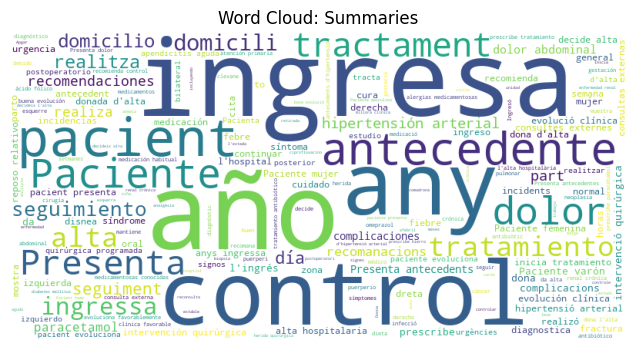

In [11]:
# Word cloud of the synthetic summaries
text = ' '.join(summaries_)
stop_words = stopwords.words('spanish') + stopwords.words('catalan')

wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          stopwords = stop_words,
                          background_color='white'
                          ).generate(text)

fig = plt.figure(1, figsize=(8, 4))
plt.axis('off')
plt.title("Word Cloud: Summaries")
plt.imshow(wordcloud)
plt.show()

#### Summaries ground truth most common ngrams

In [21]:
# Tokenize the medical reports
tokens = [nltk.word_tokenize(sent) for sent in asho_train_gt['Summary'].values.tolist()]
num_docs = len(tokens)

# Join all the tokens in a single list
tokens_joined = []
for token in tokens:
    tokens_joined += token
    
# Remove the stopwords
stop_words = stopwords.words('spanish') + stopwords.words('catalan')
stop_words = set(stop_words)

tokens_joined = [word for word in tokens_joined if word not in (stop_words)]
text = nltk.Text(tokens_joined)

In [24]:
def get_n_gram_statistics(tokens, n_gram:int = 2, num_docs:int = 1):
    # Removing punctuation
    tokens = [word for word in text if word not in (set(string.punctuation) | set(["'", '”', '“', "’", "‘", "--"]))]
    # Compute ngrams
    ngrams = list(nltk.ngrams(tokens, n_gram))
    # Counting the most common ones
    ngrams_count = Counter(ngrams)
    
    # Normalizing the counts
    ngrams_count = Counter({k: round(v/num_docs, 2) for k, v in ngrams_count.items()})
    return dict(ngrams_count.most_common(10))

print("The 10 most common 2-gram are:")
beeprint.pp(get_n_gram_statistics(text, 2, num_docs))
print("The 10 most common 3-gram are:")
beeprint.pp(get_n_gram_statistics(text, 3, num_docs))

The 10 most common 2-gram are:
{
  ('Con', 'antecedentes'): 0.3,
  ('El', 'paciente'): 0.3,
  ('Paciente', 'ingresa'): 0.3,
  ('cirrosis', 'hepática'): 0.4,
  ('habitual', 'Paciente'): 0.3,
  ('hipertensión', 'arterial'): 0.6,
  ('mejoría', 'clínica'): 0.4,
  ('procede', 'alta'): 0.3,
  ('pruebas', 'exploratorias'): 0.3,
  ('tratamiento', 'farmacológico'): 0.3,
}
The 10 most common 3-gram are:
{
  ('El', 'paciente', 'desarrolla'): 0.2,
  ('Se', 'procede', 'alta'): 0.2,
  ('antecedentes', 'hipertensión', 'arterial'): 0.3,
  ('años', 'ingresa', 'procedente'): 0.2,
  ('bajo', 'control', 'ambulatorio'): 0.2,
  ('especialistas', 'tratamiento', 'farmacológico'): 0.2,
  ('farmacológico', 'habitual', 'Paciente'): 0.2,
  ('habitual', 'Paciente', 'ingresa'): 0.2,
  ('insuficiencia', 'renal', 'aguda'): 0.3,
  ('tratamiento', 'farmacológico', 'habitual'): 0.2,
}


#### Medical reports GT most common ngrams

In [20]:
# Tokenize the medical reports
tokens = [nltk.word_tokenize(sent["Text"]) for sent in cast_data.values()]
num_docs = len(tokens)

# Join all the tokens in a single list
tokens_joined = []
for token in tokens:
    tokens_joined += token
    
# Remove the stopwords
stop_words = stopwords.words('spanish') + stopwords.words('catalan')
stop_words = set(stop_words)
tokens_joined = [word for word in tokens_joined if word not in (stop_words)]
text = nltk.Text(tokens_joined)

print("The 10 most common 2-gram are:")
beeprint.pp(get_n_gram_statistics(text, 2, num_docs))
print("The 10 most common 3-gram are:")
beeprint.pp(get_n_gram_statistics(text, 3, num_docs))

The 10 most common 2-gram are:
{
  ("d'alta", "d'hospitalitzacio"): 0.85,
  ('data', "d'alta"): 0.89,
  ('data', "d'ingres"): 0.88,
  ('data', 'naixement'): 1.1,
  ('evolucio', 'clinica'): 0.83,
  ('informe', "d'alta"): 0.86,
  ('motiu', "d'ingres"): 0.81,
  ('nbsp', 'nbsp'): 0.95,
  ('nhc', 'nbsp'): 0.95,
  ('orientacio', 'diagnostica'): 0.84,
}
The 10 most common 3-gram are:
{
  ('clinica', 'nºepisodi', 'sexe'): 0.78,
  ("d'alta", "d'hospitalitzacio", 'motiu'): 0.76,
  ("d'hospitalitzacio", 'motiu', "d'ingres"): 0.76,
  ('destinacio', "l'alta", 'domicili'): 0.76,
  ('historia', 'clinica', 'nºepisodi'): 0.78,
  ('informe', "d'alta", "d'hospitalitzacio"): 0.85,
  ('lopd', 'nº', 'historia'): 0.78,
  ('nhc', 'nbsp', 'nbsp'): 0.95,
  ('nº', 'historia', 'clinica'): 0.78,
  ('tractament', 'recomanacions', "l'alta"): 0.76,
}


# CaBreu

In [133]:
# Load the CaBreu dataset
from datasets import load_dataset
caBreu = load_dataset("projecte-aina/caBreu")

/hhome/nlp2_g05/anaconda3/envs/asho_nlp/lib/python3.8/site-packages/datasets/load.py:1461: FutureWarning: The repository for projecte-aina/caBreu contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/projecte-aina/caBreu
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [134]:
# Get all sumaries used for training
summaries_tmp = [summary["extractive"] for summary in caBreu["train"]["summaries"]]

summaries = []
for summary in summaries_tmp:
    summaries += [summary["a1"]]
    summaries += [summary["a2"]]
    summaries += [summary["a3"]]

# Get the articles
text = caBreu["train"]["content"]

In [135]:
# tokenizing the text with FLOR tokenizer
tokens_text = tokenizer(text)
tokens_summaries = tokenizer(summaries)

In [136]:
# Computing the mean number of tokens in the text and summaries
total_len_tokens_text = 0
total_len_summaries = 0

numb_documents = 2399
tokens_texts = [len(tokens_text[i]) for i in range(numb_documents)]
tokens_summaries = [len(tokens_summaries[i]) for i in range(numb_documents)]

total_len_tokens_text = sum(tokens_texts)
total_len_summaries = sum(tokens_summaries)

mean_tokens_text = total_len_tokens_text/numb_documents
mean_tokens_summaries = total_len_summaries/numb_documents

print("Mean tokens text: ", mean_tokens_text)
print("Mean tokens summaries: ", mean_tokens_summaries)

Mean tokens text:  982.0325135473114
Mean tokens summaries:  210.55481450604418


#### Lenght distribution

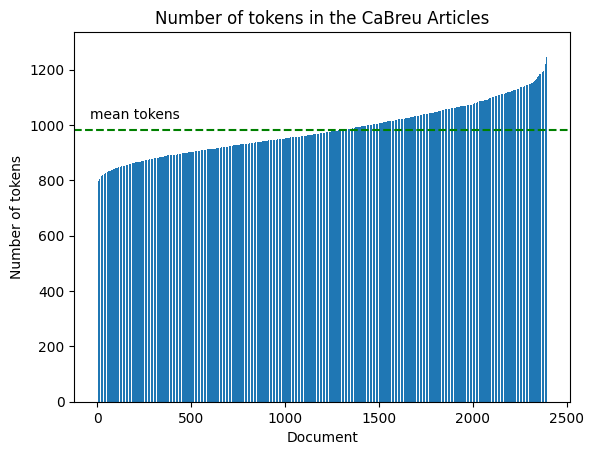

In [138]:
import matplotlib.pyplot as plt
# Plotting the number of tokens in each of the CaBreu articles

plt.bar(range(numb_documents), sorted(tokens_texts))
plt.xlabel('Document')
plt.ylabel('Number of tokens')

plt.axhline(y=mean_tokens_text, color='g', linestyle='--')

plt.text(200,  mean_tokens_text + 40, "mean tokens", ha = 'center')
plt.title('Number of tokens in the CaBreu Articles')
plt.show()


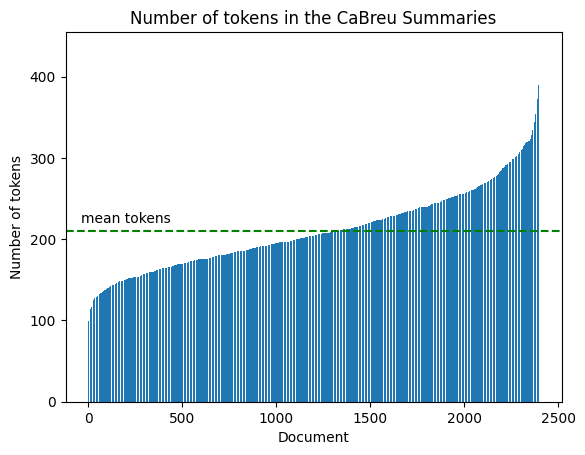

In [139]:
# Plotting the number of tokens in each of the CaBreu summaries
plt.bar(range(len(tokens_summaries)), sorted(tokens_summaries))
plt.xlabel('Document')
plt.ylabel('Number of tokens')

plt.axhline(y=mean_tokens_summaries, color='g', linestyle='--')

plt.text(200,  mean_tokens_summaries +10, "mean tokens", ha = 'center')
plt.title('Number of tokens in the CaBreu Summaries')
plt.show()

#### Wordclouds analisys:

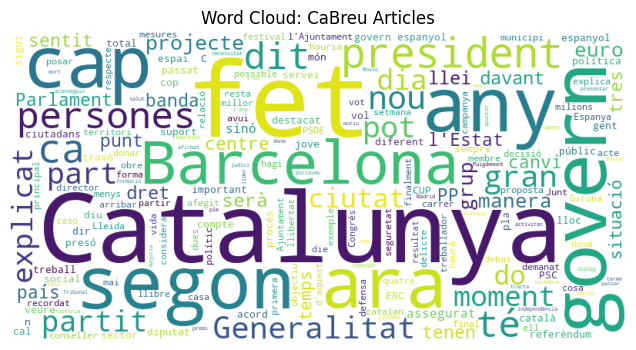

In [140]:
from nltk.corpus import stopwords
text_str = ' '.join(text)
# Words to remove from the wordcloud (stopwords and some error words)
stop_words = set(stopwords.words('spanish') + stopwords.words('catalan')) | set(["d", "s", "l"])

import matplotlib.pyplot as plt

# Articles wordclouds with stopwords and some error words removed
wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          stopwords = stop_words,
                          background_color='white'
                          ).generate(text_str)

fig = plt.figure(1, figsize=(8, 4))
plt.axis('off')
plt.title("Word Cloud: CaBreu Articles")
plt.imshow(wordcloud)
plt.show()

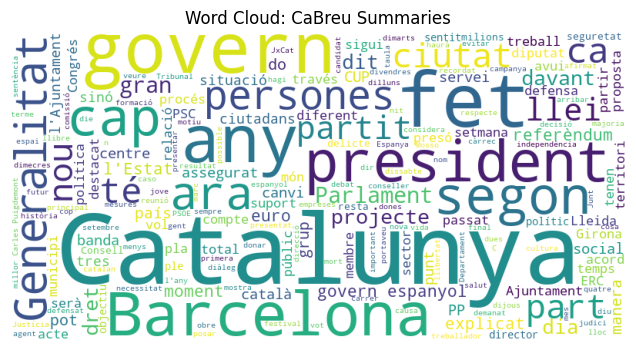

In [117]:
# Summaries wordclouds with stopwords and some error words removed
text_str = ' '.join(summaries)
stop_words = set(stopwords.words('spanish') + stopwords.words('catalan')) | set(["d", "s", "l"])

wordcloud = WordCloud(width=800, height=400,
                          relative_scaling = 1.0,
                          stopwords = stop_words,
                          background_color='white'
                          ).generate(text_str)

fig = plt.figure(1, figsize=(8, 4))
plt.axis('off')
plt.title("Word Cloud: CaBreu Summaries")
plt.imshow(wordcloud)
plt.show()